# Quantum Channel for the Ancilla Density Matrix in Random Unitary Circuit

![](RUC.png)

We are going to evaluate the effect of the matrices along the diagonal slice on the ancilla density matrix. After summing over the indices $(s_1,s_2)$ for a neighbouring pair of sites we lose the final layer by unitarity, and we are left with:

![](MPO.png)

The input ancilla density matrix $\rho_{a_1a_2a_3,\bar a_1\bar a_2 \bar a_3}$ will be contracted in at the bottom, and the indices of the output matrix $\rho'_{b_1b_2b_3,\bar b_1\bar b_2 \bar b_3}$ will pop out of the top. The task is to evaluate $\rho'$ for a given assignment of indices $b_j$ if all components of $\rho$ are known.

The first thing to notice is that the final index is traced over, lowering the dimension of the density matrix before we start. We then work from the [middle out](https://www.youtube.com/watch?v=0rhdOt9bOHE), contracting in a $U$ and $\bar U$ at each step. This is an $O(N^2)$ operation, where $N=q^d$ for depth $d$.

In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

In [4]:
from ruc_einsum import apply_gates, tensor_trace, trace_square, matrix_to_tensor, tensor_to_matrix, random_ρ, random_gates

## Complexity

In [5]:
timeit_results = []
q = 2
depths =  np.arange(5,13)
for d in depths:
    res = %timeit -o apply_gates(random_ρ(q, d), random_gates(q, d))
    timeit_results.append(res.average)

1.54 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.14 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.2 ms ± 358 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
43.4 ms ± 460 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
179 ms ± 6.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
705 ms ± 7.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.84 s ± 35.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.8 s ± 266 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check the $4^d$ scaling

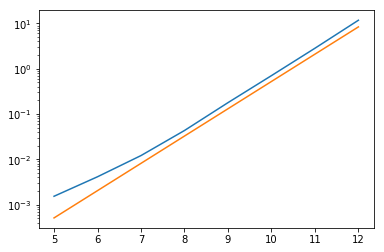

In [6]:
plt.semilogy(depths, timeit_results, depths, 0.0000005*4**depths)

## Purity

In [25]:
q = 2
depth = 7
# ρ = np.zeros(2*depth*[q])
# ρ[tuple(2*depth*[0])] = 1
ρ = random_ρ(q, depth)
purity_trace = np.array([])
eigenvalues = np.array([])

for step in range(1000):
    purity_trace = np.append(purity_trace, trace_square(ρ))
    eigenvalues = np.concatenate([eigenvalues, eigh(tensor_to_matrix(ρ), eigvals_only=True)])
    ρ = apply_gates(ρ, random_gates(q, depth))

step  0
step  1
step  2
step  3
step  4
step  5
step  6
step  7
step  8
step  9
step  10
step  11
step  12
step  13
step  14
step  15
step  16
step  17
step  18
step  19
step  20
step  21
step  22
step  23
step  24
step  25
step  26
step  27
step  28
step  29
step  30
step  31
step  32
step  33
step  34
step  35
step  36
step  37
step  38
step  39
step  40
step  41
step  42
step  43
step  44
step  45
step  46
step  47
step  48
step  49
step  50
step  51
step  52
step  53
step  54
step  55
step  56
step  57
step  58
step  59
step  60
step  61
step  62
step  63
step  64
step  65
step  66
step  67
step  68
step  69
step  70
step  71
step  72
step  73
step  74
step  75
step  76
step  77
step  78
step  79
step  80
step  81
step  82
step  83
step  84
step  85
step  86
step  87
step  88
step  89
step  90
step  91
step  92
step  93
step  94
step  95
step  96
step  97
step  98
step  99
step  100
step  101
step  102
step  103
step  104
step  105
step  106
step  107
step  108
step  109
step  110


step  844
step  845
step  846
step  847
step  848
step  849
step  850
step  851
step  852
step  853
step  854
step  855
step  856
step  857
step  858
step  859
step  860
step  861
step  862
step  863
step  864
step  865
step  866
step  867
step  868
step  869
step  870
step  871
step  872
step  873
step  874
step  875
step  876
step  877
step  878
step  879
step  880
step  881
step  882
step  883
step  884
step  885
step  886
step  887
step  888
step  889
step  890
step  891
step  892
step  893
step  894
step  895
step  896
step  897
step  898
step  899
step  900
step  901
step  902
step  903
step  904
step  905
step  906
step  907
step  908
step  909
step  910
step  911
step  912
step  913
step  914
step  915
step  916
step  917
step  918
step  919
step  920
step  921
step  922
step  923
step  924
step  925
step  926
step  927
step  928
step  929
step  930
step  931
step  932
step  933
step  934
step  935
step  936
step  937
step  938
step  939
step  940
step  941
step  942
step  943


In [26]:
-np.log(np.mean(purity_trace))

(2.0155313837563376+1.8227302345196982e-17j)

In [27]:
-np.log((4/5)**9)

2.0082919618278874

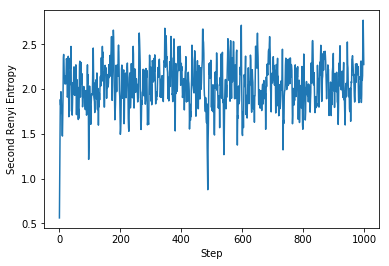

In [28]:
plt.plot(-np.log(purity_trace))
plt.xlabel("Step")
plt.ylabel("Second Renyi Entropy");

## Spectrum

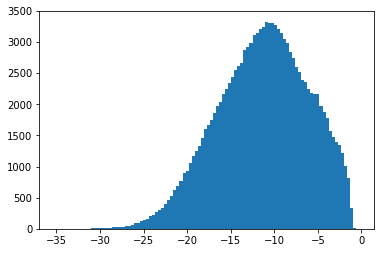

In [29]:
plt.hist(np.log(eigenvalues), bins=100);

Compare with fully random density matrix

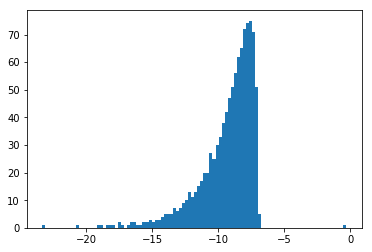

In [31]:
plt.hist(np.log(eigh(tensor_to_matrix(random_ρ(2, 10)), eigvals_only=True)), bins=100);